# Adaptivity of Posterior Variance with Data

In [2]:
import argparse
import os, sys
import time
import tabulate

import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG, SGLD

%matplotlib inline

In [3]:
model_cfg = models.PreResNet20NoAug

loaders, num_classes = data.loaders(
    "CIFAR10",
    "~/datasets/",
    10000,
    4,
    model_cfg.transform_train,
    model_cfg.transform_test,
    use_validation=False,
    split_classes=None,
    shuffle_train=False
)
loader = loaders["test"]

model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda();

Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


In [5]:
def resample(model, sigma=1):
    for p in model.parameters():
        p.copy_(torch.randn_like(p) * sigma)
        
def softmax(arr, axis=-1):
    arr_ = arr - np.max(arr, axis=axis, keepdims=True)
    return np.exp(arr_) / np.sum(np.exp(arr_), axis=axis, keepdims=True)

## Train Data

In [4]:
idx = []
y = np.array(loaders['train'].dataset.targets)
perclass = 100

for cls in range(10):
    idx += np.where(y == cls)[0][:perclass].tolist()
loaders['train'].dataset.data = loaders['train'].dataset.data[idx]
loaders['train'].dataset.targets = np.array(loaders['train'].dataset.targets)[idx]

assert len(loaders['train'].dataset) == 10 * perclass

## Test Data
We will visualize posterior samples after observing `perclass * 10` datapoints

In [6]:
for x, y in loader:
    break

mask = np.zeros_like(y).astype(bool)
classes = np.arange(10)
perclass = 20

for cls in classes:
    mask_cls = np.where(y == cls)[0]
    mask[mask_cls[:perclass]] = True

x = x[mask].cuda()
y = y[mask]

idx = np.argsort(y)
x_test = x[idx]
y_test = y[idx]

## Prior Samples

In [8]:
all_outputs = []
sigma = np.sqrt(10)
samples = 500

with torch.no_grad():
    for i in range(samples):
        resample(model, sigma=sigma)
        outputs = model(x_test).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs)
all_outputs = np.dstack(all_outputs)

<BarContainer object of 10 artists>

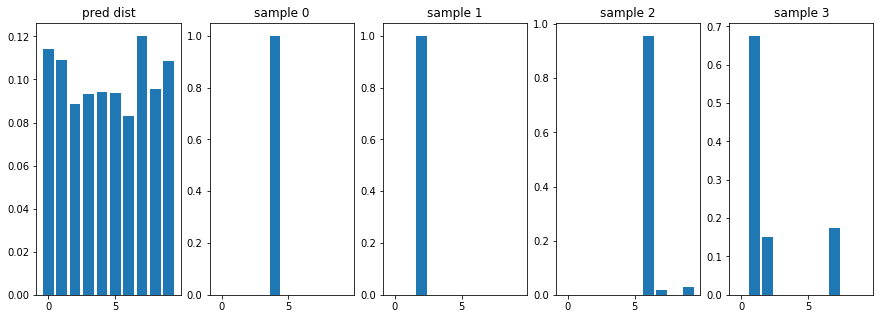

In [9]:
all_probs = softmax(all_outputs, axis=1)
f, arr = plt.subplots(1, 5, figsize=(15, 5))

for i in range(4):
        arr[i+1].set_title("sample {}".format(i))
        arr[i+1].bar(classes, all_probs[:, :, i].mean(axis=0))
arr[0].set_title("pred dist")
arr[0].bar(classes, all_probs.mean(axis=0).mean(axis=-1))

## Posterior Samples

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [11]:
with torch.no_grad():
    resample(model,0.1)
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
opt_sgld = SGLD(model.parameters(), lr=1e-3, noise_factor=1/np.sqrt(len(loaders['train'].dataset)))
criterion = losses.cross_entropy

In [12]:
all_outputs = []
sigma = np.sqrt(1e1)
epochs = 0
sgld_epochs = 5000
samples = 1

scheduler_sgld = CosineAnnealingLR(opt_sgld, T_max=sgld_epochs)

regularizer = lambda model: \
        sum([p.norm()**2 for p in model.parameters()]) / (2 * sigma**2 * len(loaders['train'].dataset))

for i in range(samples):
    with torch.no_grad():
        resample(model, sigma=sigma)
    for _ in tqdm.tqdm(range(epochs)):
        res = utils.train_epoch(loaders['train'], model, criterion, opt, regularizer=regularizer)
        
    for _ in tqdm.tqdm(range(sgld_epochs)):
        res = utils.train_epoch(loaders['train'], model, criterion, opt_sgld, regularizer=regularizer)
        scheduler_sgld.step()
    print(i, res)
    with torch.no_grad():
        outputs = model(x_test).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs)
all_outputs = np.dstack(all_outputs)

0it [00:00, ?it/s]
100%|██████████| 5000/5000 [29:43<00:00,  2.80it/s]

0 {'loss': 145.5122833251953, 'accuracy': 17.4, 'stats': {}}


<BarContainer object of 10 artists>

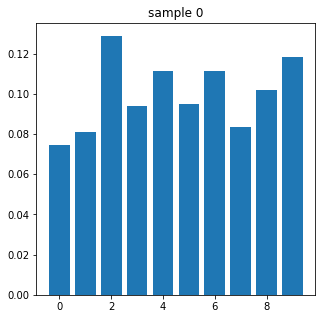

In [15]:
all_probs = softmax(all_outputs, axis=1)
f, arr = plt.subplots(1, 1, figsize=(5, 5))

arr.set_title("sample {}".format(i))
arr.bar(classes, all_probs[:, :, i].mean(axis=0))